In [207]:
# email andrew / adam booth about some of the metadata / channel localization / spacing

# are the noisey channels surface cable portions? What is the surface cable geometry?

# stack across symmetric part of the cable

# think about functions to incorporate in SeisNoise for DAS

# pmap on gpu

# remove 0 time spike- demean correlation function in frequency domain

# think about data type (float64, float16 etc) for gpu memory optimization

# better channel indexing when only a subset of correlations are desired (i.e. one source many receivers)

In [208]:
using SeisNoise, PyPlot, CUDA, Glob, HDF5, Combinatorics, Random, Statistics
import SeisIO.read_nodal
import DSP.rfft
import DSP.irfft

In [209]:
# list all the Greenland files
path = "/1-fnp/petasaur/p-wd03/greenland/Store Glacier DAS data/1kHz/"
files = glob("*",path);

In [522]:
function preprocess_nodal!(S,freqmin,freqmax)
        
    # preprocess the data
    detrend!(S)
    taper!(S)
    
    # filter the data
    bandpass!(S,freqmin,freqmax,zerophase=true)
    
    # whiten the data
    whiten!(S,freqmin,freqmax)

    # 1 bit normalization
    S.data .= sign.(S.data)

end

# consider adding sliding windows (50% overlap wouldnt be too much slower)
function correlate_windows(corr_mat,S,num_wins,win_size,maxlag)
    for n in 1:num_wins
        win_start = Int64((n-1)*win_size*S.fs[1])+1
        win_end = Int64(n*win_size*S.fs[1])
        data = S.data[win_start:win_end,:]
        C = nodalxcorr(data,maxlag)
        
        # this will need to change for more sophisticated stacking
        corr_mat = corr_mat + C
    end
    return corr_mat
end


function resample_nodal!(S,downsample_fs)
    C = CorrData(corr=S.data,fs=S.fs[1])
    resample!(C,downsample_fs)
    S.data = C.corr
    S.fs = ones(S.n)*downsample_fs
end


function correlate_data(files,win_size,maxlag,duration,chans,freqmin,freqmax,fs=nothing,mode="cpu")
    
    # read the first file and collect metadata
    S = read_nodal("segy", files[1])
    file_length = S.info["orignx"]
    num_files = Int64(duration/(file_length/S.fs[1]))
    num_wins = (file_length/(win_size*S.fs[1]))
    
    # adjust maxlag for downsampling
    if isnothing(fs) == true
        maxlag = Int64(maxlag*S.fs[1])
    else
        maxlag = Int64(maxlag*fs)
    end
    
    # make output matrix and send to gpu if necessary
    corr_mat = zeros(Int64(maxlag*2+1), Int64(size(chans)[1]*(size(chans)[1]-1)/2))
    if mode == "gpu"
        corr_mat = corr_mat |> cu
    end
    
    # loop through each file needed for the desired total duration
    for i in 1:num_files

        # read the file
        S = read_nodal("segy", files[i])[chans]
        
        if S.info["orignx"] == file_length

            # downsample the data by loading into Corr object
            if isnothing(fs) == false && fs != S.fs[1]
                resample_nodal!(S,fs)
            end
            
            # preprocess the data
            preprocess_nodal!(S,freqmin,freqmax)
                          
            # put on GPU- faster if performed above preprocess_nodal! but will have gpu filter issues
            if mode == "gpu"
                S = S |> gpu
            end
            
            # loop through data in windows
            corr_mat = correlate_windows(corr_mat,S,num_wins,win_size,maxlag)

        end

    end
    return corr_mat
end


function remove_zero_lag_spike(corr,maxlag,fs)
    
    # get transform length
    N = convert(Int, fs * maxlag*2+1)
    
    # take fourier transform, demean, and take inverse fourier transform
    FFT = rfft(corr,1)
    FFT_means = mean(FFT,dims=1)
    FFT_demean = FFT .- FFT_means    
    corr_demean = irfft(FFT_demean,N,1)
    
    return corr_demean
end


# function cross_cable_stack(chans)
    
#     # stack across the cable geometry
#     n = chans[end] - (chans[1]-1)
#     midpoint = (chans[1]-1) + Int64(n/2)

#     # get indices for desired channels 
#     indices = [j for j in combinations(chans,2)]
#     indices = reduce(vcat,transpose.(indices))

#     # leg one pairs- organize them all so surface is top of array TO DO sort by distance from surface? 
#     leg1_indices = (indices[:,1] .<= midpoint .&& indices[:,2] .<= midpoint)
    
#     # leg two pairs
#     leg2_indices = (indices[:,1] .> midpoint .&& indices[:,2] .> midpoint)
#     leg2_indices = end_chan + midpoint .- indices[leg2,:]
    
#     # cross cable pairs
#     cross_indices = (indices[:,1] .<= midpoint .&& indices[:,2] .> midpoint)

#     # leg three pairs
#     leg3_indices = (cross_indices + (reduce(vcat,sum(indices,dims=2)) .<= chans[end]+chans[1]-1) .== 2)

#     # leg four pairs
#     leg4_indices = (cross_indices + (reduce(vcat,sum(indices,dims=2)) .> chans[end]+chans[1]) .== 2)
        
#     return [leg1_indices,leg2_indices,leg3_indices,leg4_indices]
# end

remove_zero_lag_spike (generic function with 1 method)

In [523]:
function cross_cable_stack(chans)

    n = chans[end] - (chans[1]-1)
    midpoint = (chans[1]-1) + Int64(n/2)

    # get indices for desired channels
    indices = [j for j in combinations(chans,2)]
    indices = reduce(vcat,transpose.(indices))

    # get correlation functions
    corr = C.corr

    # leg one pairs- organize them all so surface is top of array TO DO sort by distance from surface? 
    leg1_indices = (indices[:,1] .<= midpoint .&& indices[:,2] .<= midpoint)
    C_leg1 = corr[:,leg1_indices]

    # leg two pairs
    i = sortperm(indices[:,2])
    sorted_indices = reverse(indices[i,:])
    sorted_corr = reverse(corr[:,i])
    leg2_indices = (sorted_indices[:,1] .> midpoint .&& sorted_indices[:,2] .> midpoint)
    C_leg2 = sorted_corr[:,leg2_indices]

    # leg three pairs
    i = sortperm(indices[:,2])
    sorted_indices2 = reverse(indices[i,:])
    sorted_corr2 = reverse(corr[:,i])
    i = sortperm(sorted_indices2[:,2])
    sorted_indices2 = reverse(sorted_indices2[i,:],dims=2)
    sorted_corr2 = reverse(sorted_corr2[:,i],dims=1)
    cross_indices = (sorted_indices2[:,1] .<= midpoint .&& sorted_indices2[:,2] .> midpoint)
    leg3_indices = (cross_indices + (reduce(vcat,sum(sorted_indices2,dims=2)) .<= chans[end]+chans[1]-1) .== 2)
    C_leg3 = sorted_corr2[:,leg3_indices]

    # leg four pairs
    i = sortperm(indices[:,1])
    sorted_indices3 = reverse(indices[i,:])
    sorted_corr3 = reverse(corr[:,i])
    i = sortperm(sorted_indices3[:,1])
    sorted_indices3 = reverse(sorted_indices3[i,:])
    sorted_corr3 = reverse(sorted_corr3[:,i])
    cross_indices = (sorted_indices3[:,1] .<= midpoint .&& sorted_indices3[:,2] .> midpoint)
    leg4_indices = (cross_indices + (reduce(vcat,sum(sorted_indices3,dims=2)) .> chans[end]+chans[1]) .== 2)
    C_leg4 = reverse(sorted_corr3[:,leg4_indices],dims=1)

    return C_leg1+C_leg2+C_leg3+C_leg4
end

cross_cable_stack (generic function with 1 method)

In [214]:
# read file
S = read_nodal("segy", files[2])

# get starting and ending channels
start_chan = 401
end_chan = S.n - (start_chan-1)
chans = collect(start_chan:end_chan)
#chans = collect(400:1344)

# set total time in seconds
duration = 2400

# set window size and maxlag for correlation
win_size = 10
maxlag = 1

# set filter parameters
freqmin, freqmax = 1,20
fs = freqmax*2+1.

# run correlation
t = @elapsed corr_mat = correlate_data(files[2:end],win_size,maxlag,duration,chans,freqmin,freqmax,fs,"gpu")

# store output in CorrData object
C = CorrData(corr=Array(deepcopy(corr_mat)),fs=fs) |> cpu

# stack analagous channel pairs
corr_stack = cross_cable_stack(chans)
C.corr = corr_stack

# postprocessing
freqmin, freqmax = 1,5
clean_up!(C,freqmin,freqmax)
abs_max!(C)

# remove zero lag spike
# C.corr = remove_zero_lag_spike(C.corr,maxlag,fs)
# corr = C.corr

LoadError: syntax: missing comma or ) in argument list

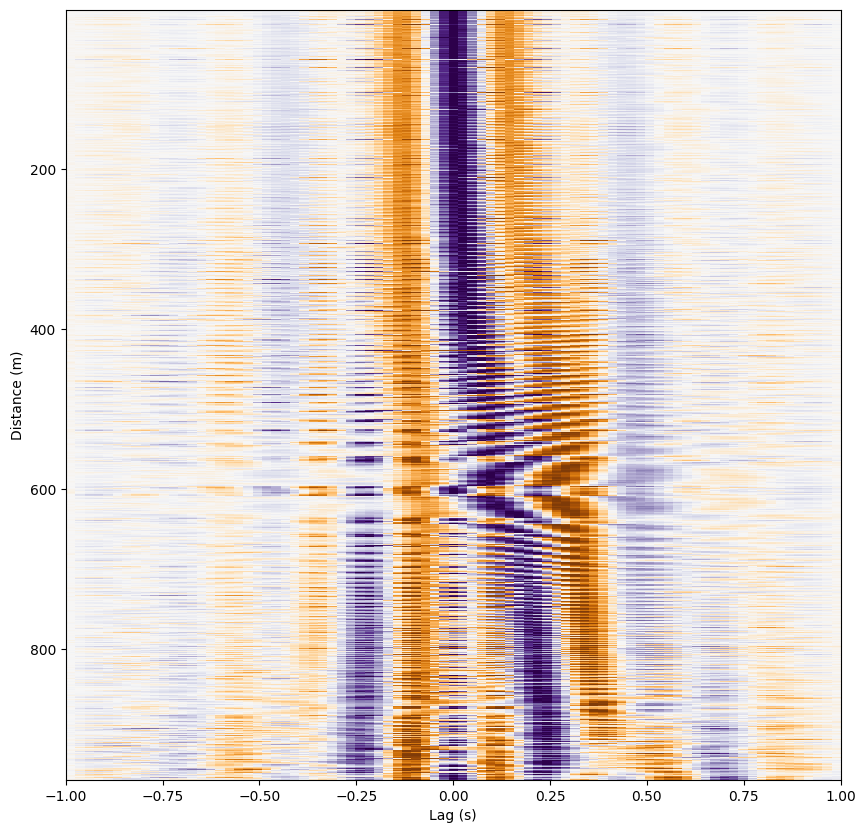

PyObject Text(0.5, 24.0, 'Lag (s)')

In [537]:
# get channel spacing
plot_chans = collect(401:1344)
indices = [j for j in combinations(plot_chans,2)]
indices = reduce(vcat,transpose.(indices))
S = read_nodal("segy", files[2])
spacing = (S.misc[4]["shot_point"]-S.misc[3]["shot_point"])/1000

# get indices for naively-sorted-by-distance plot
distance_sort = sortperm(vec(diff(indices,dims=2)))
indices = indices[distance_sort,:]
distances = round.(diff(indices,dims=2).*spacing,digits=2)

# make a plot of the correlations
figure(figsize=(10,10))
extent=[-maxlag,maxlag,maximum(distances),minimum(distances)]
imshow(C.corr[:,distance_sort]', vmin=-1, vmax=1, cmap="PuOr", interpolation=:none, aspect="auto",extent=extent)
num_rows = size(indices)[1]
ylabel("Distance (m)")
xlabel("Lag (s)")

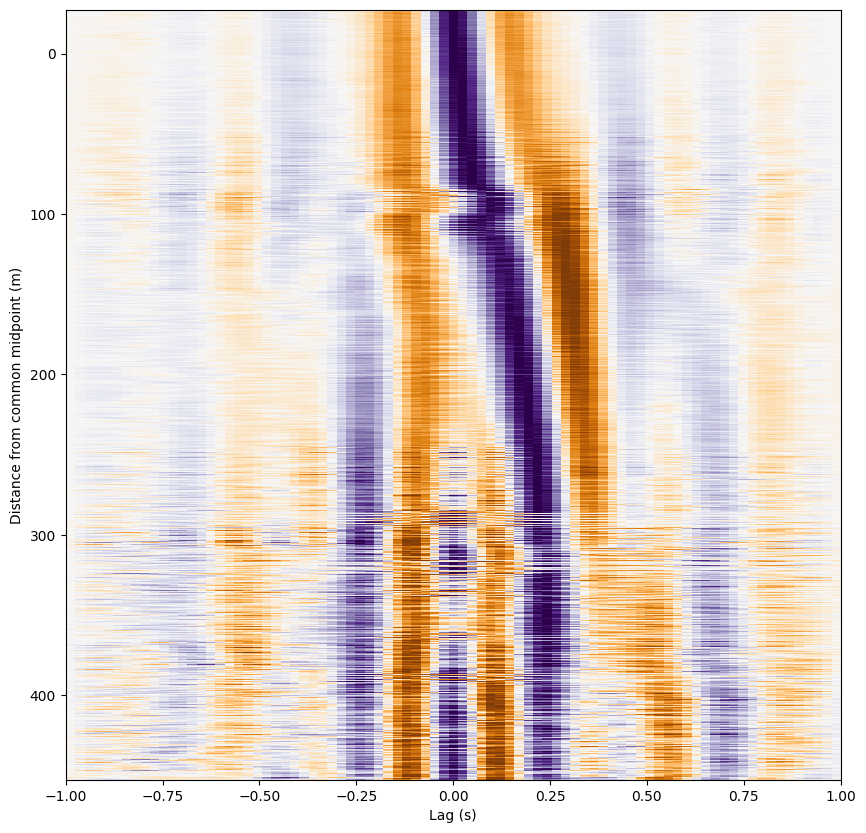

PyObject Text(0.5, 24.0, 'Lag (s)')

In [538]:
# get indices for common midpoint gather plot
indices = [j for j in combinations(plot_chans,2)]
indices = reduce(vcat,transpose.(indices))
pos = plot_chans.*spacing
midpoint = pos[div(length(pos),2)+1]
distances = indices.*spacing
center_to_midpoint = mean(distances,dims=2) .- midpoint
cmp_ind = vec(abs.(center_to_midpoint) .<  10.0)
dist_to_mid = indices[cmp_ind,2] .- midpoint

# get channel spacing
S = read_nodal("segy", files[2])
spacing = (S.misc[4]["shot_point"]-S.misc[3]["shot_point"])/1000

# make a plot of the correlations
figure(figsize=(10,10))
extent=[-maxlag,maxlag,maximum(dist_to_mid),minimum(dist_to_mid)]
imshow(reverse(C.corr[:,cmp_ind]',dims=1), vmin=-1, vmax=1, cmap="PuOr", interpolation=:none, aspect="auto",extent=extent)
ylabel("Distance from common midpoint (m)")
xlabel("Lag (s)")

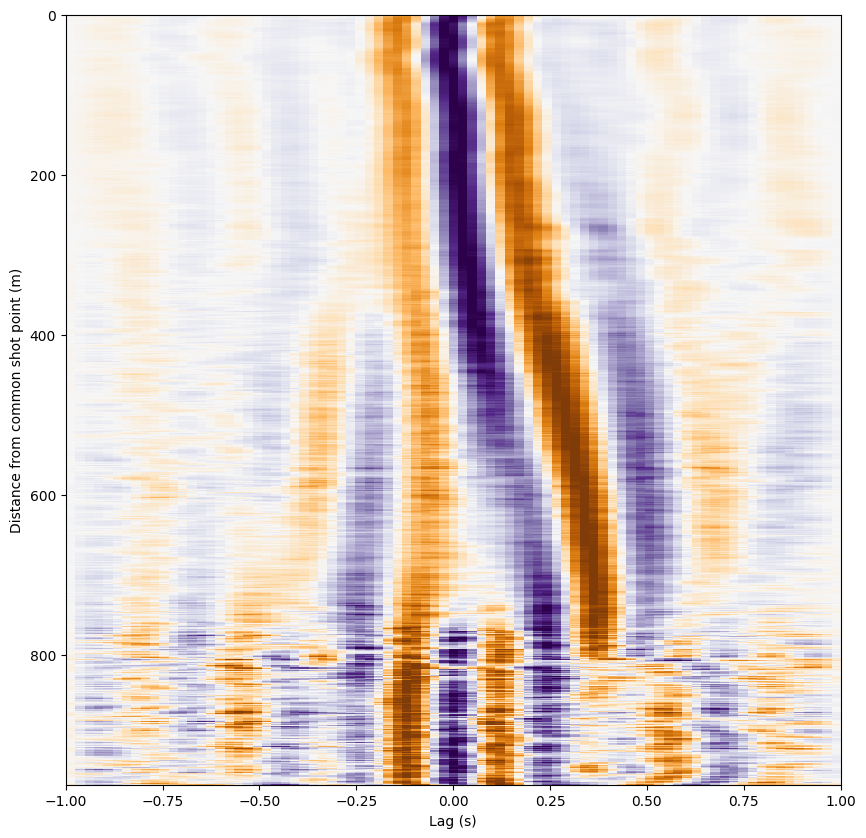

PyObject Text(0.5, 24.0, 'Lag (s)')

In [577]:
# make plot of single virtual source at the surface
indices = [j for j in combinations(plot_chans,2)]
indices = reduce(vcat,transpose.(indices))
ssp_indices = vec(indices[:,1] .== plot_chans[1])

# get channel spacing
S = read_nodal("segy", files[2])
spacing = (S.misc[4]["shot_point"]-S.misc[3]["shot_point"])/1000
profile_start = indices[ssp_indices,1][1]*spacing
profile_end = indices[ssp_indices,2][end]*spacing

# make a plot of the correlations
figure(figsize=(10,10))
extent=[-maxlag,maxlag,profile_end-profile_start,0]
imshow(stack_corr[:,ssp_ind]', vmin=-1, vmax=1, cmap="PuOr", interpolation=:none, aspect="auto",extent=extent)
ylabel("Distance from common shot point (m)")
xlabel("Lag (s)")

In [566]:
# reply to adam!
# reply to simon!!!!!!!!!!
# hope to hear from erin!!!!

943×2 Matrix{Int64}:
 401   402
 401   403
 401   404
 401   405
 401   406
 401   407
 401   408
 401   409
 401   410
 401   411
 401   412
 401   413
 401   414
   ⋮  
 401  1333
 401  1334
 401  1335
 401  1336
 401  1337
 401  1338
 401  1339
 401  1340
 401  1341
 401  1342
 401  1343
 401  1344